In [23]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns
sns.set(context="paper",font_scale=1.4)
sns_colors = sns.color_palette()

import scipy as sp
import scipy.constants as const

import sympy as sym

import pandas as pd

#import ROOT as rt

#import root_numpy as rnp

from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

/home/luckyjosh/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/luckyjosh/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

# Achsenskalierung
def axis_scale(factor, axis="x"):
    if axis == "x":
        plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    elif axis == "y":
        plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    else:
        print("Wrong axis name given! Only x and y are allowed!")

def siunitx_ticklabels(ax=None, locale="DE", xaxis=True, yaxis=True,
                       round_precision=2, round_mode="places", scale_x=None, scale_y=None):
    """
    This function uses siunitx to create the ticklabels
    Main reason is for adjusting the decimal marker properly.
    The function takes 4 arguments:
        ax=None     the matplotlib axes to operate on
                    if set to None (Standard) this will be the current axes
        locale="DE" The locale parameter for siunitx, one of
                    "UK", "US", "DE", "FR" oder "ZA"
        xaxis=True  Boolean, if True the labels for the xaxis are set
        yaxis=True  Boolean, if True the labels for the yaxis are set
        round_precision=2 Number of places or figures after rounding
        round_mode="places" Rounds to round_precision many decimal places,
                  "figures" Rounds to round_precision many significant figures
                  
    """

    if ax is None:
        ax = plt.gca()

    if scale_x == None:
        scale_x = 1
    if scale_y == None:
        scale_y = 1
        
        
    if xaxis is True:
        xticks = ax.get_xticks()
        print(xticks)
        xlabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_x) for tick in xticks]
        #print(xlabels)
        ax.set_xticklabels(xlabels)

    if yaxis is True:
        yticks = ax.get_yticks()
        ylabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_y) for tick in yticks]
        #print(ylabels)
        ax.set_yticklabels(ylabels)    
        
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)


In [5]:
%cd ../Messdaten/
%ls

/home/luckyjosh/Dokumente/Studium/Praktikum/FP_Repo/04_Diodenlaser[ ]/Messdaten
Oszilloskop_Absorbtionsspektrum.CSV
Oszilloskop_Absorbtion_Strommodulation_CH1.CSV
Oszilloskop_Absorbtion_Strommodulation_CH2.CSV
Oszilloskop_Absorbtion_Stufe1_CH1.CSV
Oszilloskop_Absorbtion_Stufe1_CH2.CSV
Oszilloskop_Absorbtion_Stufe2_CH1.CSV
Oszilloskop_Absorbtion_Stufe2_CH2.CSV
Oszilloskop_Dreieckspannung_CH1.CSV
Oszilloskop_Dreieckspannung_CH2.CSV
Strommodulation_neu_CH1.CSV
Strommodulation_neu_CH2.CSV


## Beginn der Auswertung


In [6]:
#fig, ax = plt.subplot()

### Laden der Oszilloskop-Daten

In [7]:
absorbtion_1_piezo = pd.read_csv(path_data+"Oszilloskop_Absorbtion_Stufe1_CH1.CSV",
                               skiprows=18, usecols=(3,4), names=("Zeit", "Spannung"))
absorbtion_1_diode = pd.read_csv(path_data+"Oszilloskop_Absorbtion_Stufe1_CH2.CSV",
                               skiprows=18, usecols=(3,4), names=("Zeit", "Spannung"))

In [8]:
absorbtion_1_piezo.head(5)


,Zeit,Spannung
0,-0.00008,-5.2
1,-0.00004,-5.2
2,-0.00000,-5.0
3,0.00004,-5.0
4,0.00008,-5.0


In [9]:
absorbtion_1_diode.head(5)

,Zeit,Spannung
0,-0.00008,-2.8
1,-0.00004,-2.8
2,-0.00000,-2.8
3,0.00004,-2.8
4,0.00008,-2.8


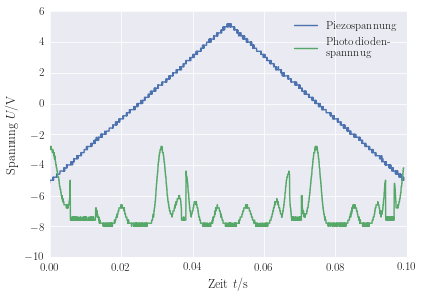

In [10]:
fig, ax = plt.subplots()
ax.set_xlim(0,0.1)
ax.set_ylim(-10,6)
ax.set_xlabel(axis_label("Zeit","t","s"))
ax.set_ylabel(axis_label("Spannung","U","V"))

ax.plot(absorbtion_1_piezo["Zeit"],absorbtion_1_piezo["Spannung"], label="Piezospannung")
ax.plot(absorbtion_1_diode["Zeit"],absorbtion_1_diode["Spannung"], label="Photodioden-\nspannnug")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Filter_nach_Laser.pdf")

In [11]:
absorbtion_2_piezo = pd.read_csv(path_data+"Oszilloskop_Absorbtion_Stufe2_CH1.CSV",
                               skiprows=18, usecols=(3,4), names=("Zeit", "Spannung"))
absorbtion_2_diode = pd.read_csv(path_data+"Oszilloskop_Absorbtion_Stufe2_CH2.CSV",
                               skiprows=18, usecols=(3,4), names=("Zeit", "Spannung"))

In [12]:
absorbtion_2_piezo.head(5)


,Zeit,Spannung
0,0.04876,5
1,0.04878,5
2,0.04880,5
3,0.04882,5
4,0.04884,5


In [13]:
absorbtion_2_diode.head(5)

,Zeit,Spannung
0,0.04876,-10.4
1,0.04878,-10.4
2,0.04880,-10.4
3,0.04882,-10.4
4,0.04884,-10.6


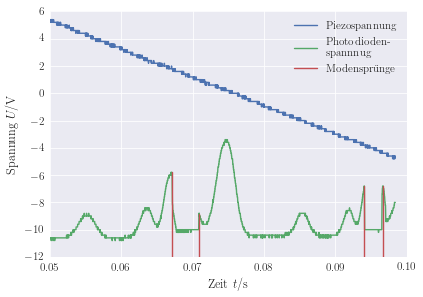

In [76]:
fig, ax = plt.subplots()
ax.set_xlim(0.05,0.1)
#ax.set_ylim(-10,6)
ax.set_xlabel(axis_label("Zeit","t","s"))
ax.set_ylabel(axis_label("Spannung","U","V"))

ax.plot(absorbtion_2_piezo["Zeit"],absorbtion_2_piezo["Spannung"], label="Piezospannung")
ax.plot(absorbtion_2_diode["Zeit"],absorbtion_2_diode["Spannung"], label="Photodioden-\nspannnug")
ax.plot([0], color=sns_colors[2], marker="",label="Modensprünge")#, linestyle="dashed")
ax.axvline(x=0.0671, ymin=0, ymax=0.345, color=sns_colors[2])#, linestyle="dashed")
ax.axvline(x=0.07088, ymin=0,ymax=0.177, color=sns_colors[2])#, linestyle="dashed")
ax.axvline(x=0.094, ymin=0,ymax=0.287, color=sns_colors[2])#, linestyle="dashed")
ax.axvline(x=0.0966, ymin=0,ymax=0.287, color=sns_colors[2])#, linestyle="dashed")

ax.legend(loc="upper right")
fig.savefig(path_graphics+"Filter_und_NDFilter.pdf")

In [15]:
current_modulation_piezo = pd.read_csv(path_data+"Strommodulation_neu_CH2.CSV",
                               skiprows=18, usecols=(3,4), names=("Zeit", "Spannung"))
current_modulation_diode = pd.read_csv(path_data+"Strommodulation_neu_CH1.CSV",
                               skiprows=18, usecols=(3,4), names=("Zeit", "Spannung"))

In [16]:
current_modulation_piezo.head(5)

,Zeit,Spannung
0,0.02412,2.32
1,0.02416,2.40
2,0.02420,2.32
3,0.02424,2.40
4,0.02428,2.40


In [17]:
current_modulation_diode.head(5)

,Zeit,Spannung
0,0.02412,7.52
1,0.02416,7.44
2,0.02420,7.36
3,0.02424,7.36
4,0.02428,7.36


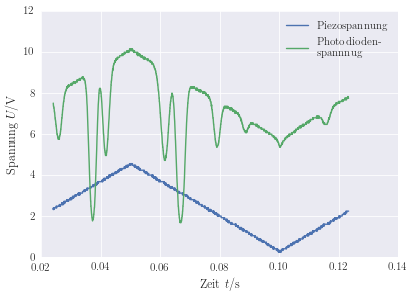

In [18]:
fig, ax = plt.subplots()
#ax.set_xlim(0.05,0.1)
#ax.set_ylim(-10,6)
ax.set_xlabel(axis_label("Zeit","t","s"))
ax.set_ylabel(axis_label("Spannung","U","V"))

ax.plot(current_modulation_piezo["Zeit"],current_modulation_piezo["Spannung"], label="Piezospannung")
ax.plot(current_modulation_diode["Zeit"],current_modulation_diode["Spannung"], label="Photodioden-\nspannnug")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Strommodulation.pdf")

In [19]:
absorbtion_spectrum = pd.read_csv(path_data+"Oszilloskop_Absorbtionsspektrum.CSV",
                               skiprows=18, usecols=(3,4), names=("Zeit", "Spannung"))



In [20]:
absorbtion_spectrum.head(5)

,Zeit,Spannung
0,0.04876,1.40
1,0.04878,1.40
2,0.04880,1.36
3,0.04882,1.36
4,0.04884,1.36


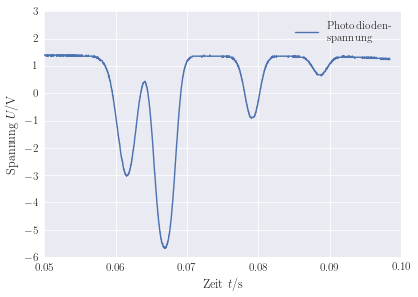

In [77]:
fig, ax = plt.subplots()
ax.set_xlim(0.05,0.1)
ax.set_ylim(-6,3)
ax.set_xlabel(axis_label("Zeit","t","s"))
ax.set_ylabel(axis_label("Spannung","U","V"))

ax.plot(absorbtion_spectrum["Zeit"],absorbtion_spectrum["Spannung"], label="Photodioden-\nspannung")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Absorptionsspektrum.pdf")

## Testbereich: